# Delta Lake vs. ORC

This notebook compares Delta Lake and ORC for processing tabular data.

## Initialize Spark

In [1]:
import os
import s3fs
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
import pyspark.sql.functions as F
from pyspark.sql import Row
import pyspark.sql.types as T
import datetime
import time
from delta import *

In [2]:
import getpass
access_key = getpass.getpass()
secret_key = getpass.getpass()

 ········
 ········


In [3]:
conf = (
    pyspark.conf.SparkConf()
    .setAppName("MY_APP")
    .set(
        "spark.sql.catalog.spark_catalog",
        "org.apache.spark.sql.delta.catalog.DeltaCatalog",
    )
    .set("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .set("spark.hadoop.fs.s3a.access.key", access_key)
    .set("spark.hadoop.fs.s3a.secret.key", secret_key)
    .set("spark.sql.shuffle.partitions", "4")
    .setMaster(
        "local[*]"
    )  # replace the * with your desired number of cores. * for use all.
)

extra_packages = [
    "org.apache.hadoop:hadoop-aws:3.3.4",
    "org.apache.hadoop:hadoop-common:3.3.4",
    "com.amazonaws:aws-java-sdk-bundle:1.12.262",
]

builder = pyspark.sql.SparkSession.builder.appName("MyApp").config(conf=conf)
spark = configure_spark_with_delta_pip(
    builder, extra_packages=extra_packages
).getOrCreate()


## Generate Data

In [7]:
# Generate sample data
num_rows = 10000000
df = spark.range(0, num_rows)

# Add columns
for i in range(1, 10):  # Since we already have one column
    if i % 2 == 0:
        # Integer column
        df = df.withColumn(f"int_col_{i}", (F.randn() * 100).cast(T.IntegerType()))
    else:
        # String column
        df = df.withColumn(f"str_col_{i}", (F.rand() * num_rows).cast(T.IntegerType()).cast("string"))

df.count()

10000000

In [16]:
# Write 4 CSVs for comparing performance for every file type
df.write.csv("data/delta-orc/ten_million_parquet.csv")
df.write.csv("data/delta-orc/ten_million_avro.csv")
df.write.csv("data/delta-orc/ten_million_orc.csv")
df.write.csv("data/delta-orc/ten_million_delta.csv")

In [4]:
# Read 3 CSVs to create dataframes
schema = T.StructType([
    T.StructField("id", T.LongType(), nullable=False),
    T.StructField("str_col_1", T.StringType(), nullable=True),
    T.StructField("int_col_2", T.IntegerType(), nullable=True),
    T.StructField("str_col_3", T.StringType(), nullable=True),
    T.StructField("int_col_4", T.IntegerType(), nullable=True),
    T.StructField("str_col_5", T.StringType(), nullable=True),
    T.StructField("int_col_6", T.IntegerType(), nullable=True),
    T.StructField("str_col_7", T.StringType(), nullable=True),
    T.StructField("int_col_8", T.IntegerType(), nullable=True),
    T.StructField("str_col_9", T.StringType(), nullable=True)
])

df_csv_parquet = spark.read.format("csv").option("header",True).schema(schema).load("data/delta-orc/ten_million_parquet.csv")
df_csv_orc = spark.read.format("csv").option("header",True).schema(schema).load("data/delta-orc/ten_million_orc.csv")
df_csv_delta = spark.read.format("csv").option("header",True).schema(schema).load("data/delta-orc/ten_million_delta.csv")

## WRITE performance

In [6]:
# Write data as ORC
start_time = time.time()
df_csv_orc.write.orc("data/delta-orc/ten_million_orc.orc")
end_time = time.time()
print(f"Time taken to write as ORC: {end_time - start_time} seconds")

Time taken to write as ORC: 6.7849647998809814 seconds


In [ ]:
# Write data as Parquet
start_time = time.time()
df_csv_parquet.write.parquet("data/delta-orc/ten_million_parquet.parquet")
end_time = time.time()
print(f"Time taken to write as Parquet: {end_time - start_time} seconds")

In [ ]:
# Write data as Delta
start_time = time.time()
df_csv_delta.write.format("delta").save("data/delta-orc/ten_million_delta.delta")
end_time = time.time()
print(f"Time taken to write as Delta Lake: {end_time - start_time} seconds")

## AGGREGATE performance

In [12]:
# Perfom aggregation query using Parquet data
start_time = time.time()
df_parquet = spark.read.parquet("data/delta-orc/ten_million_parquet2.parquet")
df_parquet \
.select("str_col_5","str_col_7","int_col_2") \
.groupBy("str_col_5","str_col_7") \
.count() \
.orderBy("count") \
.limit(1) \
.show(truncate = False)
end_time = time.time()
print(f"Time taken for query: {end_time - start_time} seconds")

+---------+---------+-----+
|str_col_5|str_col_7|count|
+---------+---------+-----+
|10       |2546663  |1    |
+---------+---------+-----+

Time taken for query: 6.530552864074707 seconds


In [13]:
# Perform aggregation using ORC data
start_time = time.time()
df_orc = spark.read.orc("data/delta-orc/ten_million_orc2.orc")
df_orc \
.select("str_col_5","str_col_7","int_col_2") \
.groupBy("str_col_5","str_col_7") \
.count() \
.orderBy("count") \
.limit(1) \
.show(truncate = False)
end_time = time.time()
print(f"Time taken for query: {end_time - start_time} seconds")

+---------+---------+-----+
|str_col_5|str_col_7|count|
+---------+---------+-----+
|0        |4653819  |1    |
+---------+---------+-----+

Time taken for query: 4.769298076629639 seconds


In [14]:
# Perform aggregation using Delta data
start_time = time.time()
df_delta = spark.read.format("delta").load("data/delta-orc/ten_million_delta2.delta")
df_delta \
.select("str_col_5","str_col_7","int_col_2") \
.groupBy("str_col_5","str_col_7") \
.count() \
.orderBy("count") \
.limit(1) \
.show(truncate = False)
end_time = time.time()
print(f"Time taken for query: {end_time - start_time} seconds")

+---------+---------+-----+
|str_col_5|str_col_7|count|
+---------+---------+-----+
|10       |2546663  |1    |
+---------+---------+-----+

Time taken for query: 6.79887580871582 seconds


## Appending Data

In [16]:
# generate data to add
num_rows = 1000
df_small = spark.range(0, num_rows)

# Add columns
for i in range(1, 10):  # Since we already have one column
    if i % 2 == 0:
        # Integer column
        df_small = df_small.withColumn(f"int_col_{i}", (F.randn() * 100).cast(T.IntegerType()))
    else:
        # String column
        df_small = df_small.withColumn(f"str_col_{i}", (F.rand() * num_rows).cast(T.IntegerType()).cast("string"))

In [17]:
# append to ORC table
df_small.write.mode("append").format("orc").save("data/delta-orc/ten_million_orc2.orc")

In [18]:
# append to Delta table
df_small.write.mode("append").format("delta").save("data/delta-orc/ten_million_delta2.delta")

### what does this look like on disk?

In [ ]:
# ORC

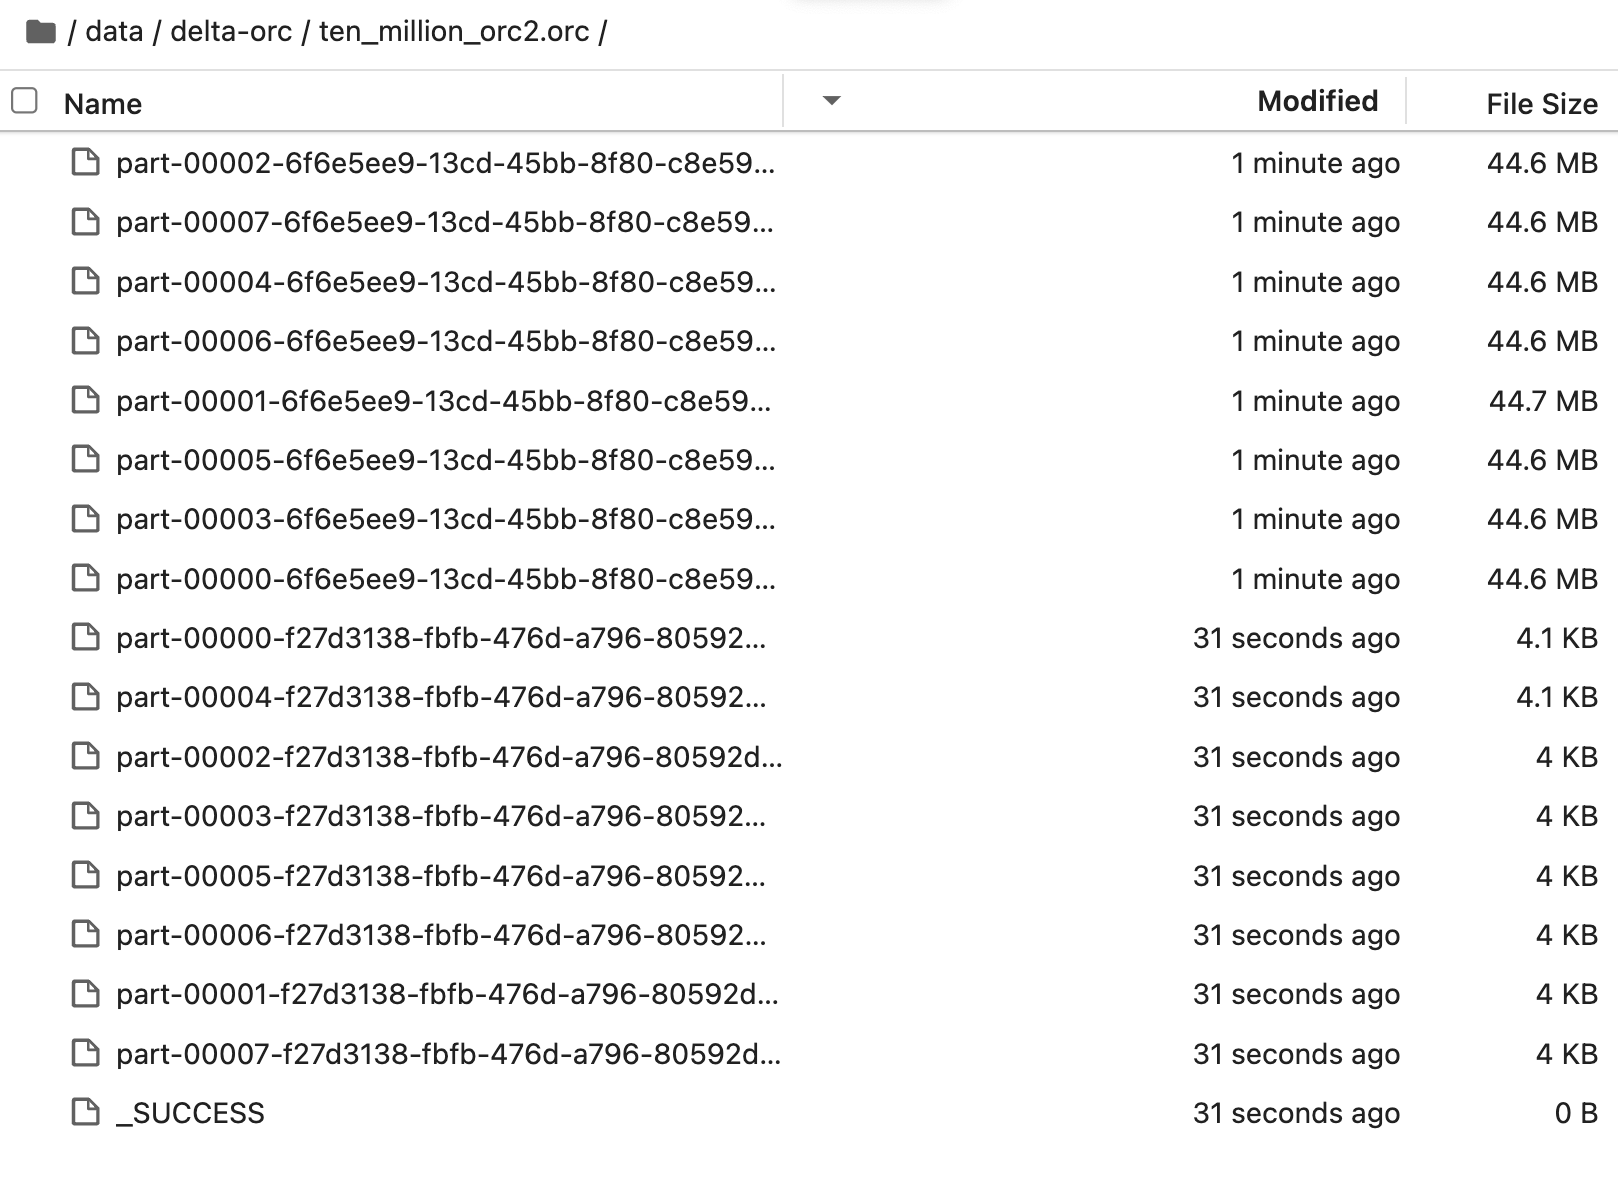

In [10]:
# Delta

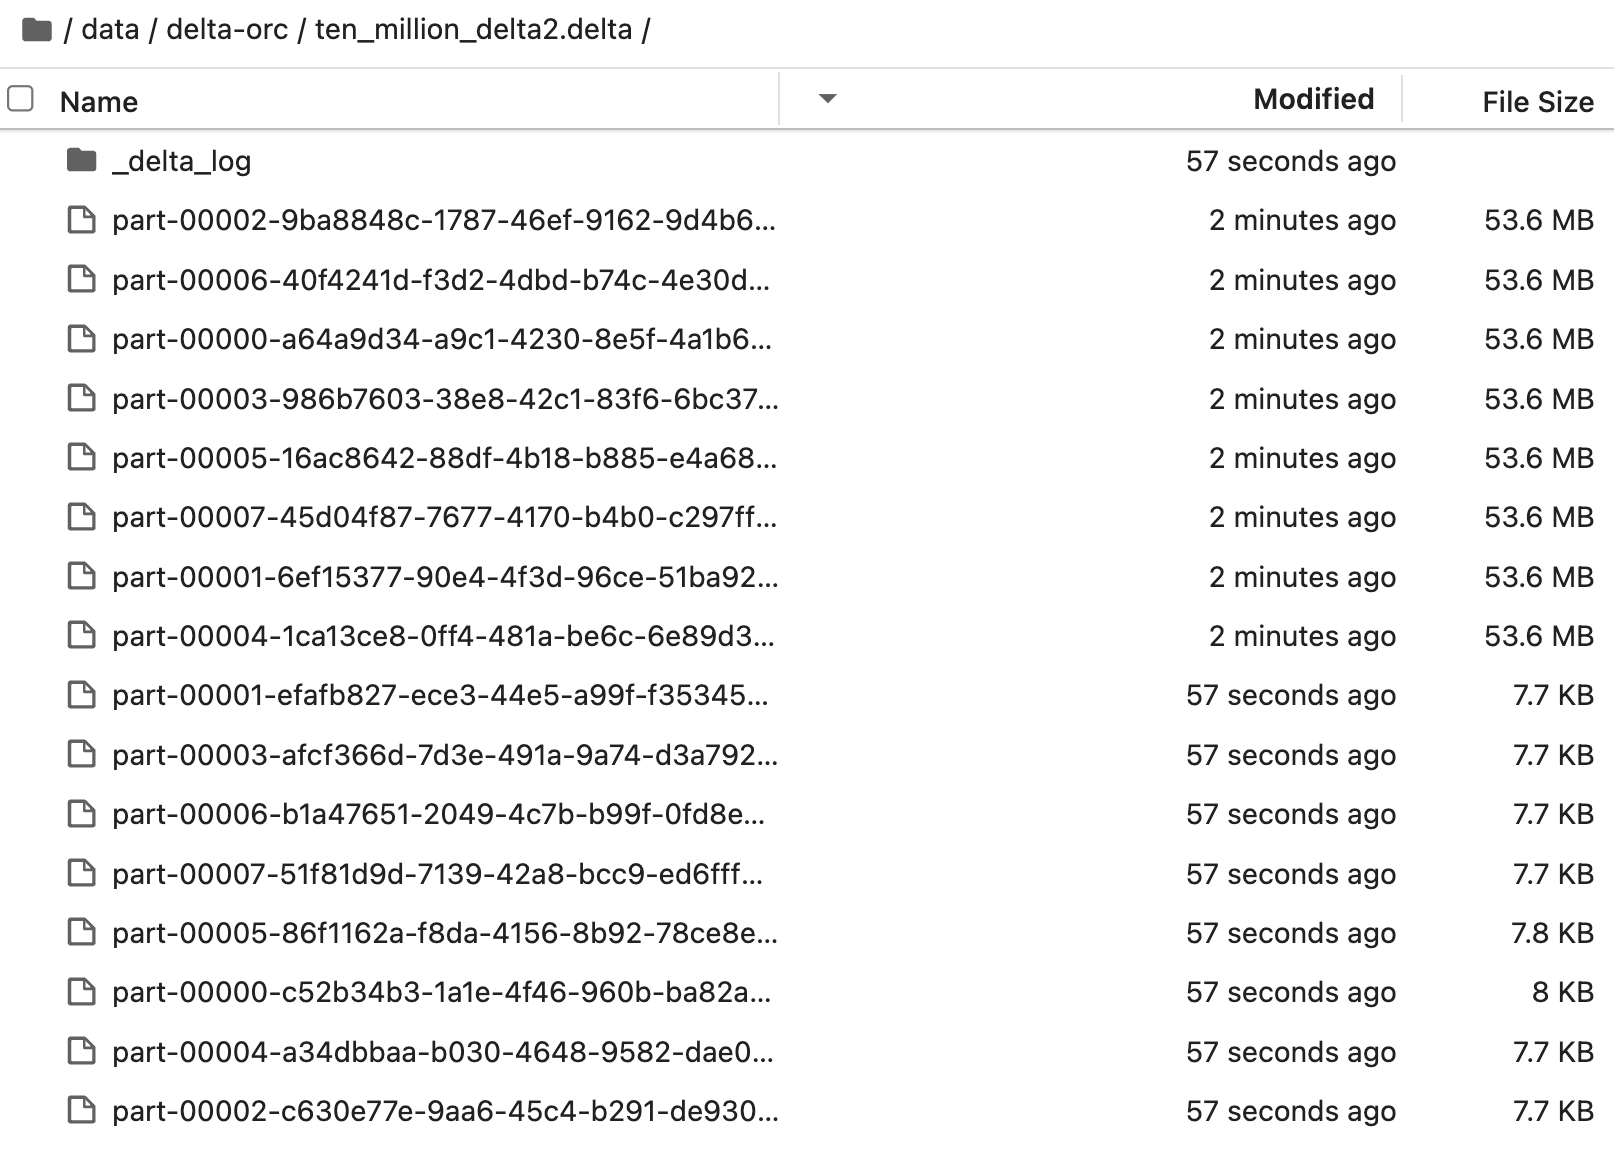

### can we travel / roll back to previous version?

In [28]:
# roll back with ORC
spark.read.format("orc").option("versionAsOf", "0").load("data/delta-orc/ten_million_orc2.orc/").count()

10000992

NO

In [24]:
# roll back with Delta
spark.read.format("delta").option("versionAsOf", "0").load("data/delta-orc/ten_million_delta2.delta/").count()

9999992

YES

### what about appending data with a different schema?

In [29]:
# generate data to add
num_rows = 1000
df_schema = spark.range(0, num_rows)

# Add columns
for i in range(1, 5):  # Since we already have one column
    if i % 2 == 0:
        # String column
        df_schema = df_schema.withColumn(f"str_col_{i}", (F.rand() * num_rows).cast(T.IntegerType()).cast("string"))
    else:
        # Integer column
        df_schema = df_schema.withColumn(f"int_col_{i}", (F.randn() * 100).cast(T.IntegerType()))

In [30]:
# append different schema with ORC
df_schema.write.mode("append").format("orc").save("data/delta-orc/ten_million_orc2.orc")

WORKS

In [40]:
# generate data to add
num_rows = 3
df1 = spark.range(0, num_rows)

# Add columns
for i in range(1, 5):  # Since we already have one column
    if i % 2 == 0:
        # String column
        df1 = df1.withColumn(f"str_col_{i}", (F.rand() * num_rows).cast(T.IntegerType()).cast("string"))
    else:
        # Integer column
        df1 = df1.withColumn(f"int_col_{i}", (F.randn() * 100).cast(T.IntegerType()))

df1.write.format("orc").save("data/delta-orc/append_example.orc")

In [45]:
df1.show()

+---+---------+---------+---------+---------+
| id|int_col_1|str_col_2|int_col_3|str_col_4|
+---+---------+---------+---------+---------+
|  0|      -55|        1|      -63|        1|
|  1|      110|        0|       21|        2|
|  2|       25|        1|       25|        2|
+---+---------+---------+---------+---------+



In [41]:
# generate data to add
num_rows = 3
df2 = spark.range(0, num_rows)

# Add columns
for i in range(1, 5):  # Since we already have one column
    if i % 2 == 0:
        # Integer column
        df2 = df2.withColumn(f"int_col_{i}", (F.randn() * 100).cast(T.IntegerType()))
    else:
        # String column
        df2 = df2.withColumn(f"str_col_{i}", (F.rand() * num_rows).cast(T.IntegerType()).cast("string"))

df2.write.format("orc").mode("append").save("data/delta-orc/append_example.orc")

In [44]:
df2.show()

+---+---------+---------+---------+---------+
| id|str_col_1|int_col_2|str_col_3|int_col_4|
+---+---------+---------+---------+---------+
|  0|        0|        0|        0|       85|
|  1|        2|      135|        2|      -48|
|  2|        1|       23|        0|      167|
+---+---------+---------+---------+---------+



In [43]:
df_append = spark.read.format("orc").load("data/delta-orc/append_example.orc/")
df_append.show(truncate=False)

+---+---------+---------+---------+---------+
|id |int_col_1|str_col_2|int_col_3|str_col_4|
+---+---------+---------+---------+---------+
|1  |110      |0        |21       |2        |
|2  |NULL     |NULL     |NULL     |NULL     |
|1  |NULL     |NULL     |NULL     |NULL     |
|0  |NULL     |NULL     |NULL     |NULL     |
|2  |25       |1        |25       |2        |
|0  |-55      |1        |-63      |1        |
+---+---------+---------+---------+---------+



In [31]:
# append different schema with Delta
df_schema.write.mode("append").format("delta").save("data/delta-orc/ten_million_delta2.delta")

AnalysisException: [_LEGACY_ERROR_TEMP_DELTA_0007] A schema mismatch detected when writing to the Delta table (Table ID: 507af1b2-6029-46b0-9345-9576ca6ecc80).
To enable schema migration using DataFrameWriter or DataStreamWriter, please set:
'.option("mergeSchema", "true")'.
For other operations, set the session configuration
spark.databricks.delta.schema.autoMerge.enabled to "true". See the documentation
specific to the operation for details.

Table schema:
root
-- id: long (nullable = true)
-- str_col_1: string (nullable = true)
-- int_col_2: integer (nullable = true)
-- str_col_3: string (nullable = true)
-- int_col_4: integer (nullable = true)
-- str_col_5: string (nullable = true)
-- int_col_6: integer (nullable = true)
-- str_col_7: string (nullable = true)
-- int_col_8: integer (nullable = true)
-- str_col_9: string (nullable = true)


Data schema:
root
-- id: long (nullable = true)
-- int_col_1: integer (nullable = true)
-- str_col_2: string (nullable = true)
-- int_col_3: integer (nullable = true)
-- str_col_4: string (nullable = true)

         

`"A schema mismatch detected when writing to the Delta table"`

## Overwriting Data

In [49]:
# overwrite ORC table
df_small.write.mode("overwrite").format("orc").save("data/delta-orc/ten_million_orc2.orc")

In [50]:
spark.read.format("orc").load("data/delta-orc/ten_million_orc2.orc/").count()

1000

In [ ]:
WORKS, but no rollback.

## ACID Transactions

## 